In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 8 + "%s" % nowtime)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [24]:
# 一、准备数据！！！！！
# cifar2数据集为cifar10数据集的子集，
# 只包括前两种类别airplane和automobile。 
# 训练集有airplane和automobile图片各5000张，
# 测试集有airplane和automobile图片各1000张。 
# <cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。>

# 在Pytorch中构建图片数据管道通常有两种方法。 
# 第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。
# 第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑
# 然后用 DataLoader来并行加载。 
# 第二种方法是读取用户自定义数据集的通用方法，
# 既可以读取图片数据集，也可以读取文本数据集。

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

transform_train = transforms.Compose([transforms.ToTensor()])
transform_valid = transforms.Compose([transforms.ToTensor()])

ds_train = datasets.ImageFolder("C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/cifar2/train",
                               transform = transform_train, target_transform= lambda t:torch.tensor([t]).float())

ds_valid = datasets.ImageFolder("C:/Users/JayphoneLin/Desktop/PYTORCH_IN_20_DAYS_in_desktop/data/cifar2/test",
                               transform = transform_train, target_transform= lambda t:torch.tensor([t]).float())

print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [25]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=0) 
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=0)

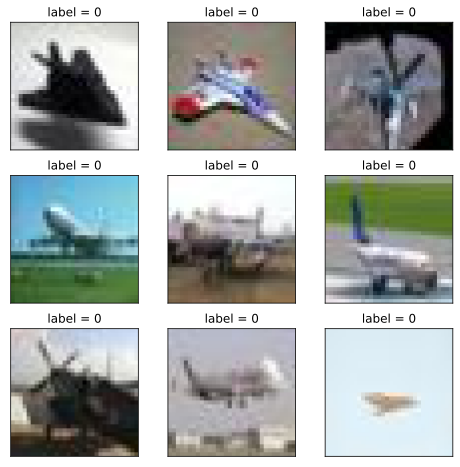

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt

# 1. 查看部分样本图片

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [27]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
for x,y in dl_train:
    print(x.shape,y.shape) 
    break
    
    
# 在这里本来是运行失败的。
# 将做以下修改才能运行成功：

#  cell4中的 ax.set_title("label = %d"%label.item())
    
#     改成：
    
#     ax.set_title("label = %d"%label)
    
#     也就是去掉 .item()

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


In [28]:
# 二、定义模型！！！！！！！！！！！
# 使用Pytorch通常有三种方式构建模型：
# 使用nn.Sequential按层顺序构建模型，
# 继承nn.Module 基类构建自定义模型，
# 继承nn.Module基类构建模型并辅助应用模型容器 (nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。 
# 此处选择通过继承nn.Module基类构建自定义模型

# 1. 测试AdaptiveMaxPool2d的效果 
pool= nn.AdaptiveAvgPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape

torch.Size([10, 8, 1, 1])

In [58]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)        
        x = self.pool(x)        
        x = self.conv2(x)        
        x = self.pool(x)        
        x = self.dropout(x)        
        x = self.adaptive_pool(x)        
        x = self.flatten(x)        
        x = self.linear1(x)       
        x = self.relu(x)        
        x = self.linear2(x)        
        y = self.sigmoid(x)        
        return y
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [59]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

In [ ]:
# 三、训练模型！！！！！！！！
# Pytorch通常需要用户编写自定义训练循环，
# 训练循环的代码风格因人而异。 
# 有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。 
# 此处使用一种较通用的函数形式训练循环